In [3]:
import numpy as np
import random
import operator
import os

from operator import itemgetter
from sklearn.datasets.samples_generator import make_blobs, make_moons, make_circles
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

# Gaussian Mixture Model Exercise

Now that you know all the theory, its time to get your hands dirty!
You will be asked to implement your own version of the GMM clustering algorithm based on the the things you (hopefully) learned in class.  
In order to test your algorithm, we will provide you an human brain MRI scan image and your task would be to segment the image into 3 different brain tissues: White Matter (WM), Gray Matter (GM) and Cerebrospinal Fluid (CSF).  
If you want to know some more about the human brain structure, please refer to the following link:  
https://en.wikipedia.org/wiki/Human_brain  

In this part, we provide you a skeleton for implementation.
The main function is called GMM(dataSet, k) and you should write the subliminary functions that it uses. These functions will include all of the relevant code for the GMM method.  

But first, you will need to build the initialization functions. 
Please implement:  
**getRandomMeans(numFeatures, k):** (you can use the provided getUniformRandom(feature) for help)  
**getRandomCovariances(numFeatures, k):**  
**getRandomWeights(k):**  

Think of the following things:
1. What are the scales of the features?
2. Is it best to initialize the Gaussians with large or small covariance?
3. What is the best initialization for the weights? Creative ways would be appreciated!


1 - The features should be in a scale from 0 to 1 since the dataset should be normalized.

2 - The covariance should be small but not so tiny that we do not have heat in our algo. 

3 - All the weights should sum up to 1, so we can sample the weight of features from a uniform distributions in a way that they respect this constraint.

In [30]:
def getUniformRandom(lower_boundary, higher_boundary):
    return random.uniform(lower_boundary, higher_boundary)

def getRandomMeans(numFeatures, k):
    means = [getUniformRandom(0,1) for x in xrange(k)]
    return  means

def getRandomCovariances(numFeatures, k):
    covs = [getUniformRandom(0.05,0.1) for x in xrange(k)]
    return  covs  

def getRandomWeights(k):
    RWeights = np.random.dirichlet(np.ones(k),size=1)
    return RWeights[0]

[ 0.18825331  0.07184351  0.73990318]


Finished? good :)
Now try and build the main block of funtions that will be the core of your algorithm:

**def getWeightsPerSample(dataSet, weights, means, covariances):**      #Calculate the "belonging" factors  
**def getWeights(weightsPerSample, k):**                                #Calculate the wieghts ofthe model  
**def getMeans(dataSet, weightsPerSample, covariances):**               #Calculate the means of the model  
**def getCovariances(dataSet, weightsPerSample, means):**               #Calculate the covariances of the model  

Remember what we learned in class and "follow the math"...

Think of potential problems that can accure (deviding by zero...anyone?)

In [52]:
from scipy.stats import multivariate_normal

# This is the Tik parameyter of the presentation
def getWeightsPerSample(dataSet, weights, means, covariances):
    
    weigthPerSample = []
    for d in dataSet:
        temp_T = []
        total_result = 0
        for k in xrange(len(weights)):
            temp = weights[k]*multivariate_normal.pdf(d, mean=means[k], cov=covariances[k])
            temp_T.append(temp)
        temp_T = temp_T/np.sum(temp_T)
        weigthPerSample.append(temp_T.tolist())
        
    return weigthPerSample

def getMeans(dataSet, weightsPerSample, covariances):
    
    means = []
    for k in xrange(len(covariances)):
        result_k = 0
        temp_denominator = 0
        for idx, d in enumerate(dataSet):
            result_k += d*weightsPerSample[idx][k]
            temp_denominator += weightsPerSample[idx][k]
        result_k = result_k/temp_denominator
        means.append(result_k.tolist())
    
    return means   
        
def getCovariances(dataSet, weightsPerSample, means):
    
    covs = []
    for k in xrange(len(means)):
        result_k = 0
        temp_denominator = 0
        for idx, d in enumerate(dataSet):
            result_k += (d-means[k])*(d-means[k])*weightsPerSample[idx][k]
            temp_denominator += weightsPerSample[idx][k]
        result_k = result_k/temp_denominator
        covs.append(result_k.tolist())
    
    return covs   

def getWeights(weightsPerSample, k_):
    
    weights = []
    for k in xrange(k_):
        result_k = 0
        for idx, v in enumerate(weightsPerSample):
            result_k += weightsPerSample[idx][k]
        result_k = result_k/len(weightsPerSample)
        weights.append(result_k)
    
    return weights 

# run GMM (and compare to histogram)
# k = 3
# dataSetClass = dataSet(X, labels)
# dataSetTest = dataSet(X_full_size, labels)

# numFeatures = dataSetClass.getNumFeatures()
# means = getRandomMeans(numFeatures, k)
# covariances = getRandomCovariances(numFeatures, k)
# weights = getRandomWeights(k)

# temp = getWeightsPerSample(dataSetClass.getData(), weights, means, covariances)
# weights = getWeights(temp, k)
# means = getMeans(dataSetClass.getData(), temp, covariances)
# covs = getCovariances(dataSetClass.getData(), temp, means)
# print covs

#### If you want to see the temporal image histogram 
# x_values, x_axis = np.histogram(X,bins=20)
# plt.plot(x_axis[1:21], x_values)
# plt.show()

# weights, means, covariances = GMM(dataSetClass, K)

[[0.0009099309145067], [3.108056963663523e-08], [0.027609065324531164]]


Please see the structure of the main function 'GMM' and the 'dataSet' class for storing the input data.  

Note that currentlly the stopping condition of the EM algorithm is only the iteration number. after you finnish it all, and you think that you want to implement the log-likelihood based stopping function, feel very free to do so. 

In [53]:
from scipy.spatial import distance
from scipy.stats import multivariate_normal
import sys

MAX_ITERATIONS = 30 

### Main Gaussian Mixture Model Function    
def GMM(dataSet, k):  
    # Initialize parameters randomly
    numFeatures = dataSet.getNumFeatures()
    means = getRandomMeans(numFeatures, k)
    covariances = getRandomCovariances(numFeatures, k)
    weights = getRandomWeights(k)
    
    # Initialize book keeping vars.
    iterations = 0
   
    # Run the main GMM algorithm
    weightsPerSampleDict  = {}
    while not shouldStop(iterations):
        iterations += 1
        
        weightsPerSample  = getWeightsPerSample(dataSet.getData(), weights, means, covariances)
        weights           = getWeights(weightsPerSample, k)
        means             = getMeans(dataSet.getData(), weightsPerSample, covariances)
        covariances       = getCovariances(dataSet.getData(), weightsPerSample, means)
        
    print (iterations) 
    
    return (weights, means, covariances)


def likelihoodCondition(weightsOld,weightsNew,meansOld,meansNew,covOld,covNew):
    return True

def shouldStop(iterations):
    if iterations > MAX_ITERATIONS:
        return True
    else:
        return False
    
    
#The main class the data set is stored in
class dataSet:   
    def __init__(self, X, labels):
        self._X = X
        self._labels = labels
        self._numFeatures = X.shape[1]
        self._numOfLabels = len(np.unique(labels))
        
    def getNumFeatures(self,):
        return self._numFeatures 
    
    def getLabels(self,):
        return  self._labels
    
    def getData(self,):
        return self._X


You think you got what it takes?!

Now let's try to cluster real data.
Think of image intensity normaliztion and wherever it is needed for the algorithm.  

The following section includes all the code for image reading and pre processing.   

The MRI image in a 4d image with the sizes of [256,128,256,1].  
Feel free to play with the image slices and watch the magnifisent beuty of the human brain :)

**Please install package nibabel using pip**

In [54]:
from scipy.misc import toimage
from matplotlib import pyplot as plt
import os
import numpy as np
import nibabel as nib

current_path = os.getcwd()

# Read brain file
example_filename = current_path + r"\\IBSR_05_ana_strip.nii.gz"
img = nib.load(example_filename)
img_data = img.get_data()

# Read label file
example_filename_label = current_path + r"\\IBSR_05_segTRI_fill_ana.nii.gz"
img_label = nib.load(example_filename_label)
img_data_label = img_label.get_data()

# Take picture number 125 and make the image smaller
partImage = img_data[40:215, :, 125, 0]
partImageLabel = img_data_label[40:215, :, 125, 0]
partShape = partImage.shape

# Flatten the images and remove zero values
imgFlatt = partImage.flatten()
ix_no_zero = np.where(imgFlatt!=0)
newImage = imgFlatt[ix_no_zero]
ix_zero = np.where(imgFlatt==0)

# Image intensity normaliztion
X = (newImage - np.min(newImage))/(np.max(newImage) - np.min(newImage))
X_full_size = (imgFlatt - np.min(newImage))/(np.max(newImage) - np.min(newImage))

# Shape sizes calculations
size = X.shape[0]
size_full = X_full_size.shape[0]

# Reshape the images for better fit
X = X.reshape(size, 1)
X_full_size = X_full_size.reshape(size_full, 1)

labels = np.ones((size, 1))

The following section includes the GMM process itself

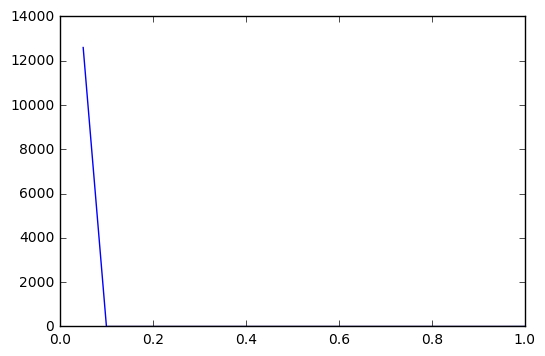

LinAlgError: singular matrix

In [56]:
# run GMM (and compare to histogram)
K = 3
dataSetClass = dataSet(X, labels)
dataSetTest = dataSet(X_full_size, labels)

#### If you want to see the temporal image histogram 
x_values, x_axis = np.histogram(X,bins=20)
plt.plot(x_axis[1:21], x_values)
plt.show()

weights, means, covariances = GMM(dataSetClass, K)

If you want to test your work and get the results.  
Please use the current function:  

(Note, the function will work on weightsPerSampleTest of type 'dict', if any other type used, please write the final for loop by yourself)

In [20]:
def testData(testSet, weights, means, covariances): 
    weightsPerSampleTest = getWeightsPerSample(testSet, weights, means, covariances)
    X = testSet.getData()
    n = len(X)
    res = np.empty(0)
    for i in range(n):
        stats = weightsPerSampleTest[i]
        res = np.append(res, max(stats.items(), key=operator.itemgetter(1))[0])
    return res

In [21]:
# Test your code on the given image (Make sure the test function fits)
d = testData(dataSetTest, weights, means, covariances)
d[ix_zero] = 3;
d = d.reshape(partShape)

NameError: name 'weights' is not defined

If you want to visualize the images, please remove remarks from the relevant image. 

In [ ]:
#### Show image intensity
# plt.figure(1)
# plt.imshow(partImage, cmap='gray')
# plt.show()

#### Show image labels
# plt.figure(2)
# plt.imshow(partImageLabel)
# plt.show()

#### Show image segmentation
# plt.figure(3)
# plt.imshow(d)
# plt.show()